In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.stats import f_oneway, uniform

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import kernel_metrics, chi2_kernel
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

`sklearn.metrics.pairwise.kernel_metrics()` to list available kernels

In [2]:
kernel_metrics()

{'additive_chi2': <function sklearn.metrics.pairwise.additive_chi2_kernel(X, Y=None)>,
 'chi2': <function sklearn.metrics.pairwise.chi2_kernel(X, Y=None, gamma=1.0)>,
 'linear': <function sklearn.metrics.pairwise.linear_kernel(X, Y=None, dense_output=True)>,
 'polynomial': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'poly': <function sklearn.metrics.pairwise.polynomial_kernel(X, Y=None, degree=3, gamma=None, coef0=1)>,
 'rbf': <function sklearn.metrics.pairwise.rbf_kernel(X, Y=None, gamma=None)>,
 'laplacian': <function sklearn.metrics.pairwise.laplacian_kernel(X, Y=None, gamma=None)>,
 'sigmoid': <function sklearn.metrics.pairwise.sigmoid_kernel(X, Y=None, gamma=None, coef0=1)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_similarity(X, Y=None, dense_output=True)>}

Each of these are interesting in their own ways, but the most applicable to our case will be `additive_chi2` and `chi2`, `linear`, `rbf` and `laplacian`. We will do trials of each, but `rbf` will be approximated using the `sklearn.kernel_approximation.Nystroem` method since it is intractable with so many samples especially if we need to enable probability prediction.

## Data Read

In [3]:
#d_full = pd.read_csv('../data/d_full.csv')

d_sub = pd.read_csv('../data/d_sub.csv')

x, y = *(d_sub.drop('label', axis=1),
         d_sub['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

## SGD Initialization

In [4]:
sgd = SGDClassifier(loss='log',
                    penalty='l1',
                    #early_stopping=True,
                    class_weight='balanced',
                    n_jobs=-1)

## Example Nystroem Approximation

In [5]:
chi2_approx = Nystroem(kernel='rbf').fit_transform(x, y)
chi2_approx

array([[0.08845568, 0.07216576, 0.08726705, ..., 0.11692979, 0.11734943,
        0.11644536],
       [0.08695516, 0.07559107, 0.08748049, ..., 0.11760009, 0.11674162,
        0.11705415],
       [0.08983877, 0.07112498, 0.08979463, ..., 0.11457186, 0.11790346,
        0.11724058],
       ...,
       [0.1151198 , 0.07187098, 0.07634676, ..., 0.16599191, 0.10283782,
        0.10773759],
       [0.11613657, 0.07057447, 0.07626907, ..., 0.1628356 , 0.10380283,
        0.10759665],
       [0.08322453, 0.07277476, 0.08423869, ..., 0.11379849, 0.11590459,
        0.11357438]])

In [6]:
scores = cross_val_score(sgd, chi2_approx, y, scoring='precision_micro', cv=5)
scores

array([0.68208546, 0.59662877, 0.57428459, 0.60995688, 0.59607843])

In [7]:
scores = cross_val_score(sgd, chi2_approx, y, scoring='recall_micro', cv=5)
scores

array([0.70952568, 0.5876127 , 0.58604469, 0.625245  , 0.56823529])

In [8]:
def train(clf, x, y, kernel='rbf', scoring=None, folds=5, verbose=0, **kwargs):
    approx = Nystroem(kernel=kernel, kernel_params=dict(**kwargs)).fit_transform(x, y)
    return cross_val_score(clf,
                           approx, y,
                           scoring=scoring,
                           cv=StratifiedKFold(n_splits=folds, shuffle=True),
                           verbose=verbose, n_jobs=-1)

## Trials

In [9]:
#np.set_printoptions(precision=2)
sgd = SGDClassifier(loss='log',
                    penalty='l1',
                    #early_stopping=True,
                    #class_weight='balanced',
                    n_jobs=-1, warm_start=False)
kernels_to_try = ('additive_chi2', 'chi2', 'linear', 'rbf', 'laplacian')
scoring = 'recall_weighted'
folds=10
df = {}
for kernel in kernels_to_try:
    scores = train(sgd,
                   x, y,
                   folds=folds,
                   kernel=kernel,
                   scoring=scoring)
    df[kernel] = scores
    print(kernel, ' done...')
f_result = f_oneway(*df.values())
df = pd.DataFrame(df)
df

additive_chi2  done...
chi2  done...
linear  done...
rbf  done...
laplacian  done...


,additive_chi2,chi2,linear,rbf,laplacian
0,0.656740,0.670063,0.637147,0.643417,0.644984
1,0.647335,0.673197,0.642633,0.623824,0.646552
2,0.659091,0.661442,0.642633,0.629310,0.673197
3,0.652038,0.684169,0.639498,0.642633,0.674765
4,0.655686,0.672941,0.637647,0.648627,0.674510
5,0.645490,0.672941,0.627451,0.654902,0.648627
6,0.664314,0.680000,0.657255,0.640784,0.665098
7,0.642353,0.687843,0.638431,0.628235,0.677647
8,0.656471,0.687059,0.626667,0.646275,0.664314
9,0.653333,0.687843,0.643137,0.652549,0.657255


In [10]:
df.mean()

additive_chi2    0.653285
chi2             0.677750
linear           0.639250
rbf              0.641056
laplacian        0.662695
dtype: float64

In [11]:
f_result

F_onewayResult(statistic=27.107181167842075, pvalue=1.746987420585839e-11)

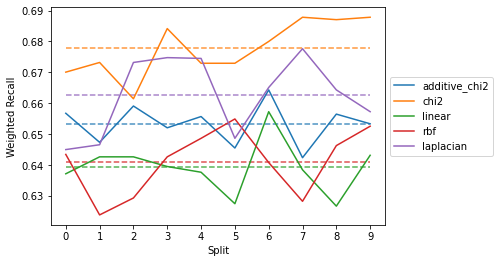

In [12]:
ax = df.plot(use_index=True, xticks=range(folds))
ax.hlines(df.mean(),
          xmin=0, xmax=folds-1,
          linestyles='dashed', alpha=0.8, colors=['C'+str(i) for i in range(5)])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.xlabel('Split');
plt.ylabel('Weighted Recall');

$\chi^2$ does best on average across several runs, so we will use it as our real kernel.

In [27]:
param_grid = {'kernel__n_components': np.linspace(100, 600, num=10, dtype=int),
              'kernel__gamma': np.logspace(-3, 3, num=10),
              'clf__loss': ('hinge', 'log'),
              'clf__penalty': ('l2', 'l1'),
              #'learning_rate': ('optimal', 'invscaling', 'adaptive'),
              #'power_t': np.logspace(-3, -1, num=10),
              'clf__class_weight': ('balanced', None)
             }

pipeline_steps = [('kernel', Nystroem(kernel='chi2')), ('clf', SGDClassifier(average=True))]

In [28]:
#fm = Nystroem(kernel='chi2', n_components=300).fit_transform(x, y)

pl = Pipeline(pipeline_steps)

grid = RandomizedSearchCV(estimator=pl,
                          cv=5, scoring='recall_weighted',
                          param_distributions=param_grid,
                          verbose=3, n_jobs=-1)

grid.fit(x,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.3s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('kernel',
                                              Nystroem(kernel='chi2')),
                                             ('clf',
                                              SGDClassifier(average=True))]),
                   n_jobs=-1,
                   param_distributions={'clf__class_weight': ('balanced', None),
                                        'clf__loss': ('hinge', 'log'),
                                        'clf__penalty': ('l2', 'l1'),
                                        'kernel__gamma': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                                        'kernel__n

In [29]:
grid_df = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
grid_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel__n_components,param_kernel__gamma,param_clf__penalty,param_clf__loss,param_clf__class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,3.537802,0.215032,0.102801,0.012512,544,6.15848,l2,log,balanced,"{'kernel__n_components': 544, 'kernel__gamma':...",0.716190,0.649941,0.604861,0.609565,0.567059,0.629523,0.050668,1
0,3.640401,0.121854,0.120398,0.007501,544,0.162378,l2,log,balanced,"{'kernel__n_components': 544, 'kernel__gamma':...",0.673461,0.591925,0.561740,0.592317,0.555686,0.595026,0.042011,2
9,1.288800,0.087579,0.016603,0.003661,100,0.0379269,l2,hinge,balanced,"{'kernel__n_components': 100, 'kernel__gamma':...",0.673461,0.582517,0.558604,0.591533,0.547059,0.590635,0.044389,3
4,1.285344,0.125196,0.018602,0.001496,100,233.572,l1,log,None,"{'kernel__n_components': 100, 'kernel__gamma':...",0.536260,0.566445,0.512740,0.523324,0.540000,0.535754,0.018135,4
7,1.897800,0.140564,0.016800,0.001165,100,0.00206914,l1,log,balanced,"{'kernel__n_components': 100, 'kernel__gamma':...",0.440220,0.439044,0.444532,0.454724,0.542353,0.464174,0.039478,5
1,3.197992,0.279645,0.079200,0.006112,155,1000,l1,log,balanced,"{'kernel__n_components': 155, 'kernel__gamma':...",0.426891,0.415131,0.402979,0.402587,0.420392,0.413596,0.009584,6
6,4.563199,0.330279,0.075202,0.005492,377,0.00885867,l1,log,balanced,"{'kernel__n_components': 377, 'kernel__gamma':...",0.633085,0.329675,0.441788,0.467268,0.134510,0.401265,0.164938,7
3,2.390457,0.078001,0.026400,0.001854,155,0.00206914,l1,log,balanced,"{'kernel__n_components': 155, 'kernel__gamma':...",0.273618,0.437083,0.378283,0.467268,0.149412,0.341133,0.116458,8
5,5.563397,0.358000,0.134200,0.005193,600,0.162378,l1,log,None,"{'kernel__n_components': 600, 'kernel__gamma':...",0.259506,0.150529,0.139553,0.208154,0.124314,0.176411,0.050309,9
2,3.899910,0.270453,0.057000,0.001096,322,0.001,l1,hinge,None,"{'kernel__n_components': 322, 'kernel__gamma':...",0.138769,0.125049,0.125049,0.125049,0.125098,0.127803,0.005483,10
